# `overlay` - Testing overlay/overlap, merging, intersection and union operations

This notebook aims at testing the [`overlay`](https://github.com/eurostat/pygridmap/blob/master/pygridmap/overlay.py) module of the [`pygridmap`](https://github.com/eurostat/pygridmap) packages by running basic/simple examples over the `GridOverlay` class. We also compare the areal interpolation as introduced in the `pygridmap.overlay` module with the available algorithm available in the [`tobler`](https://github.com/pysal/tobler) package (see [comparison](#ComparisonTobler)). 

This class implements the algorithm for vector overlay operations, it is used for tile-based implementation of geometric intersection, overlay/overlap and merging of vector layers (see [tests](#TestGridOverlay)). The `GridOverlay` class mostly relies on the use of the `geopandas` built-in method [`overlay`](https://geopandas.org/reference/geopandas.overlay.html) (see also [set operations](https://geopandas.org/set_operations.html)).

## Settings<a id='Settings'></a>

Let's import the necessary packages. First the basic ones:

In [1]:
_THISDIR_ = !pwd 
_THISDIR_ = _THISDIR_[0]

import os, sys
import requests
import warnings
import json
import math, time, timeit
import itertools, functools

then, common (geospatial) data handling libraries:

In [2]:
import numpy as np

try:
     import pandas as pd
except ImportError:
    try:
        !{sys.executable} -m pip install pandas
    except:
        raise IOError("!!! Error importing pandas - this package is required !!!")
    else:
        import pandas as pd
        
try:
    import geopandas as gpd
except ImportError:
    try:
        !{sys.executable} -m pip install geopandas
    except:
        raise IOError("!!! Error importing geopandas - this package is required !!!")
    else:
        import geopandas as gpd
        
DUMMYCOL = '__pop__'

We also set the CPUs capabilties of this machine:

In [3]:
import multiprocessing as mp

NPROCESSES = NCPUS = mp.cpu_count() 
print("You are running on a machine with \033[1m%s CPUs\033[0m" % NCPUS)

You are running on a machine with 32 CPUs


We import the `matplotlib` plotting package:

In [4]:
import matplotlib.pyplot as mplt
from matplotlib import cm
_FIGSIZE_, _DPI_ = (20,15), 140 
%matplotlib inline

We also import mapping capabilities through the [`folium`](https://python-visualization.github.io/folium/) package for visualisation (you could consider using [`ipyleaflet`](https://ipyleaflet.readthedocs.io/en/latest/) instead):

In [5]:
try:
    import folium
except ImportError:
    try:
        !{sys.executable} -m pip install folium
    except:
        pass # print("!!! Error importing folium !!!")
    else:
        import folium

try:
    import branca
except ImportError:
    try:
        !{sys.executable} -m pip install branca
    except:
        pass # print("!!! Error importing branca !!!")
finally:
    import branca.colormap as bcm

Finally, we import the `pygridmap` package ( _"whatever works"_ ):

In [6]:
try:
    import pygridmap
except ImportError:
    try:
        # import google.colab
        !{sys.executable} -m pip install git+https://github.com/eurostat/pygridmap.git
        # !{sys.executable} -m pip install pygridmap
    except:
        raise IOError("Sorry, you're doomed: package pygridmap not installed !")
    else:
        print("! Package pygridmap installed on-the-fly !")
finally:        
    from pygridmap.base import NPROCESSES, NCPUS, FrameProcessor, GridProcessor
    from pygridmap.gridding import DEFPROJ, GridMaker
    from pygridmap.overlay import GridOverlay
    from pygridmap.apps import area_interpolate

## Test data<a id='GISCO'></a>

Throughout this notebook, we will set the coverage domain to the internal borders of an arbitrary selected country hence considering the borders as masking geometries for gridding. Using the grid maker, we will build a regular grid over the spatial domain defined by the masking geometries. Note that those geometries are usually multiple, *e.g.* islands are part of the given country. 

Data acquired over Italy (`CTRY_NAME`) are used in this notebook. We will actually retrieve [GISCO](https://ec.europa.eu/eurostat/web/gisco) 2020 reference dataset (`YEAR`) of the country borders at $1m$ resolution (`RESOLUTION`) for the "test data" (`GISCO_BORDER`). We set the reference projection (`PROJECTION`) to the Lambert Azimuthal Equal-Area coordinate system ([ETRS89 LAEA](https://spatialreference.org/ref/epsg/etrs89-etrs-laea/), see also [EPSG:23035](https://epsg.io/3035). This system preserves areas:

In [7]:
CTRY_CODE = 'BE'
YEAR = 2020
RESOLUTION = '01m' # 1m finest resolution
PROJECTION = "EPSG:3035" # DEFPROJ
PROJ = PROJECTION.split('EPSG:')[1]

Data are fetched from the [_GISCO_ API](https://gisco-services.ec.europa.eu/distribution/v2/). Visit the [NUTS API webpage](https://gisco-services.ec.europa.eu/distribution/v2/countries/) for more information:

In [8]:
CTRY = '%s-region-%s-%s-%s' % (CTRY_CODE, RESOLUTION, PROJ, YEAR)
FMT = 'geojson'

try:
    CTRY_NAME = '%s.%s' % (CTRY, FMT)
    assert (os.path.exists(CTRY_NAME) is True)
except:
    CTRY_FILE = ('https://gisco-services.ec.europa.eu/distribution/v2/countries/distribution/%s' 
                 % CTRY_NAME)
    try:
        print("Connecting to GISCO webserver")
        resp = requests.get(CTRY_FILE)
        resp.raise_for_status()
    except:
        raise IOError("Error fetching GISCO data: %s" % CTRY_FILE)
    else:
        !wget -O $CTRY_NAME "$CTRY_FILE"
        print('GISCO %s country border data loaded on-disk: \033[1m%s\033[0m' % (CTRY_CODE, CTRY_NAME))
finally:
    GISCO_BORDER = gpd.read_file(CTRY_NAME, driver = FMT)

We report here the min/max coordinates $[x_\min, y_\min, x_\max, y_\max]$ of the spatial domain. This information is used to define the reference bounding box (`GRID_BBOX` and `GRID_FRAME`) of the test dataset:

In [9]:
xmin, ymin, xmax, ymax = GISCO_BORDER.total_bounds

print("Min/max of (x,y) coordinates: \033[1mXmin=%s, Ymin=%s, Xmax=%s, Ymax=%s\033[0m" 
      % (xmin, ymin, xmax, ymax))
print("Extent of the bounding box defined by the (x,y) coordinates: \033[1mX: %sm (%skm) -- Y: %sm (%skm)\033[0m" % 
      (xmax-xmin, round((xmax-xmin)/1000), ymax-ymin, round((ymax-ymin)/1000)))

GRID_BBOX = [xmin, ymin, xmax, ymax] # GISCO_BORDER.total_bounds.tolist()
# GRID_FRAME = GridProcessor.bbox_to_geoframe(*GRID_BBOX, crs=PROJECTION)
GRID_FRAME = GridProcessor.bbox_to_geoframe(*GRID_BBOX, density=50, crs=PROJECTION)

Min/max of (x,y) coordinates: Xmin=3799789.0, Ymin=2941705.0, Xmax=4065319.0, Ymax=3167881.0
Extent of the bounding box defined by the (x,y) coordinates: X: 265530.0m (266km) -- Y: 226176.0m (226km)


Similarly, we fetch NUTS data to later use as a dummy dataset. Visit [_GISCO_ API webpage](https://gisco-services.ec.europa.eu/distribution/v2/nuts/) for more information:

In [10]:
RESOLUTION = RESOLUTION.upper() # '01M'
YEAR = 2021
LEVEL = 3

NUTS = 'NUTS_RG_%s_%s_%s_LEVL_%s' % (RESOLUTION, YEAR, PROJ, LEVEL)
FMT = 'geojson'

try:
    NUTS_NAME = '%s.%s' % (NUTS, FMT)
    assert (os.path.exists(NUTS_NAME) is True)
except:
    NUTS_FILE = ('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/%s'
                 % NUTS_NAME)
    try:
        print("Connecting to GISCO webserver")
        resp = requests.get(NUTS_FILE)
        resp.raise_for_status()
    except:
        raise IOError("Error fetching NUTS data: %s" % NUTS_FILE)
    else:
        !wget -O $NUTS_NAME "$NUTS_FILE"
        print('GISCO NUTS borders data loaded on-disk: \033[1m%s\033[0m' % NUTS_NAME)
finally:
    NUTS_RG = gpd.read_file(NUTS_NAME, driver = FMT) # 'GeoJSON' or 'Geojson': both work
    NUTS_RG = NUTS_RG.loc[NUTS_RG.FID.apply(lambda x: x.startswith(CTRY_CODE))] 
    NUTS_RG.drop(columns = ['FID','COAST_TYPE','MOUNT_TYPE','URBN_TYPE',
                           'CNTR_CODE','NAME_LATN','LEVL_CODE'], 
                 inplace = True)

We add some dummy quantitative variables / features (`DUMMYCOL` #1 and #2) to this dataset:

In [11]:
NUTS_RG[DUMMYCOL] = 100 * np.random.random(size = NUTS_RG.shape[0])
# NUTS_RG = NUTS_RG.assign(**{DUMMYCOL: 100*np.random.random(size = NUTS_RG.shape[0])})

# adding area (not necessary)
NUTS_RG[GridOverlay.COL_AREA] = NUTS_RG.area    
#def __area(data):
#    data[GridOverlay.COL_AREA] = data.area
#    return data
#proc = FrameProcessor(cores = NPROCESSES)
#NUTS_RG = proc(NUTS_RG, __area)

Let's visualise the data used for testing:

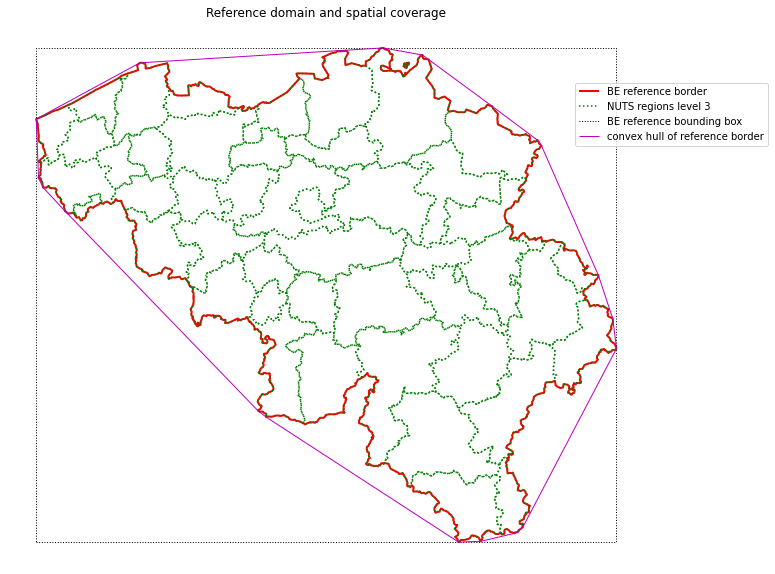

In [12]:
f, ax = mplt.subplots(1,1, figsize = (15,10)) # _FIGSIZE_
GISCO_BORDER.boundary.plot(ax = ax, edgecolor = 'r', linewidth = 2, 
                           label = '%s reference border' % CTRY_CODE) 
NUTS_RG.boundary.plot(ax = ax, edgecolor = 'g', linewidth = 1.5, linestyle = 'dotted', 
                      label='NUTS regions level %s' % LEVEL) 
GRID_FRAME.boundary.plot(ax = ax, edgecolor = 'k', linewidth = 1, linestyle = 'dotted', 
                         label = '%s reference bounding box' % CTRY_CODE)
GISCO_BORDER.convex_hull.boundary.plot(ax = ax, edgecolor = 'm', linewidth = 1, 
                                       label = 'convex hull of reference border')
ax.set_title('Reference domain and spatial coverage')
ax.set_axis_off(); ax.legend(bbox_to_anchor=(1.2, .9))
mplt.show()

## Miscellaneous tests<a id='TestOverlay'>

The `GridOverlay` class essentially performs the geometric intersection or union (`how`) of two vector layers, a (supposedly fine and regular) grid with a (supposedly coarser) polygon representation (see method `process_split_tile`). Namely, given a grid $\mathbf{G} = \mathbf{G}({\cal s})$ of unit cells of "resolution" ${\cal s}$ (in meters) and a polygon representation $\mathbf{P}$, this supports the generation of two types of output vector layer:
1. in the case no rule is passed (*e.g.*, `rule=None` below), a vector layer $\mathbf{I}$ corresponding to the intersection (*ibid*, union) of grid cells is created with vector polygons:
$$
\mathbf{I} 
\doteq \mathbf{G} \; \bigcap \; \mathbf{P}
= \; \bigcup_{\mathbb{C} \, \in \, \mathbf{G} \;\land \; \mathbb{P} \, \in \, \mathbf{P}} \;
\big\{ \mathbb{C} \cap \mathbb{P}\big\}
$$
where every polygon $\mathbb{I} \doteq \mathbb{C} \cap \mathbb{P} \in \mathbf{I}$ for any pair $(\mathbb{C},\mathbb{P}) \in \mathbf{G} \times \mathbf{P}$ is assigned a new feature $\cal A_{\%}$ that verifies $\cal A_{\%} (\mathbb{I}) \doteq \cal A (\mathbb{I}) \,/\, {\cal A} (\mathbb{P}) = \cal A (\mathbb{C} \cap \mathbb{P}) \,/\, {\cal A} (\mathbb{P})$; note that $\cal A_{\%} (\mathbb{I})$ and $\cal A (\mathbb{I})$ are stored in columns `GridOverlay.COL_PCT` and `GridOverlay.COL_AREA` respectively,
2. in the case a rule (`rule`) is defined and a (set of) numeric feature(s) $\cal F$ (*e.g.*, any quantitative variable $\cal P$ like `DUMMYCOL`) is passed with the layer $\mathbf{P}$, a new vector layer $\mathbf{G'} = \{\mathbf{G}, {\cal F'}\}$ with the same geometries (unit cells) as $\mathbf{G}$ is created with a new feature $\cal F'$ assigned to each unit cell $\mathbb{C} \in \mathbf{G}$. In the case `rule=sum` for instance, common areal interpolation (see also [next section](#ComparisonTobler)) is performed so that:
$$
{\cal F'}(\mathbb{C}) 
= \; \sum_{\mathbb{P} \in \mathbf{P}} \;
\big[{\cal F}(\mathbb{P}) \times \frac{{\cal A} (\mathbb{C} \cap \mathbb{P})}{{\cal A} (\mathbb{P})}\big]
$$
where obviously the sum is taken over all intersecting polygons $\mathbb{P} \in \mathbf{P}$ so that $\mathbb{P} \cap  \mathbb{C} \neq \emptyset$. This can be further expressed considering the previous vector layer $\mathbf{I}$ as:
$$
{\cal F'}(\mathbb{C}) 
= \; \sum_{\mathbb{I} \in \mathbf{I}}
\big[{\cal F}(\mathbb{P}) \times A_{\%} (\mathbb{I})\big]
$$
where the sum is also taken over all interior polygons $\mathbb{I} \in \mathbf{I}$ so that $\mathbb{I} \cap \mathbb{C} \neq \emptyset$ representing the fraction of the cell $\mathbb{C}$ covered by each polygon $\mathbb{P}$. The estimation of ${\cal F'}$ is actually just a matter of projecting the polygon representation onto the regular unit grid.

The methods `overlay_polygon_grid`, `area_overlay`, `cover_overlay` and `attribute_overlay` of the `GridOverlay` class implement the operations above <a id='GridOverlay'></a>. We run a first test aiming at verifying dummy identity preservation, *i.e.* that an input vector layer is preserved when the geometric union/intersection operations (`HOW`) is run with itself: <a id='Test0'></a>

In [13]:
def testGridOverlay_0(cellsize, how, rule):
    # create a dumb grid over the country area
    proc = GridMaker(cores = NPROCESSES, mode = 'prll', tile = 2, # whatever, we test ...
                     cell = cellsize)
    grid = proc(GRID_BBOX, mask = GISCO_BORDER, crs = PROJECTION, trim = True, drop = True)
    
    grid[DUMMYCOL] = list(range(grid.shape[0])) # 100*np.random.random(size = grid.shape[0])
       
    proc = GridOverlay(cores = NPROCESSES, cell = cellsize, tile = 1, # why not
                       how = how)
    overlayed = proc(grid, grid, rule = rule, columns = DUMMYCOL)
    
    overlayed = overlayed.sort_values(GridOverlay.COL_GRIDX, ignore_index=True)
    
    try:
        assert all(overlayed[DUMMYCOL] == grid[DUMMYCOL])
    except:
        raise IOError('!!! Testing identity preservation for geometric %s: \033[1mERROR\033[0m !!!' % how)
    else:
        print('Testing identity preservation for geometric %s: \033[1mOK\033[0m' % how)
        
    return grid
 
CELLSIZE = [50000, 50000] 
RULE = 'sum'

HOW = 'union'
_ = testGridOverlay_0(CELLSIZE, HOW, RULE)

HOW = 'intersection'
grid = testGridOverlay_0(CELLSIZE, HOW, RULE)

Testing identity preservation for geometric union: OK
Testing identity preservation for geometric intersection: OK


We test the effect of scale reduction (resolution increase by a factor `NSCALE`) on a dummy quantitative variable (`DUMMYCOL`) when applying the equal distribution of the variable values over the smaller scales (`RULE = 'sum'`):

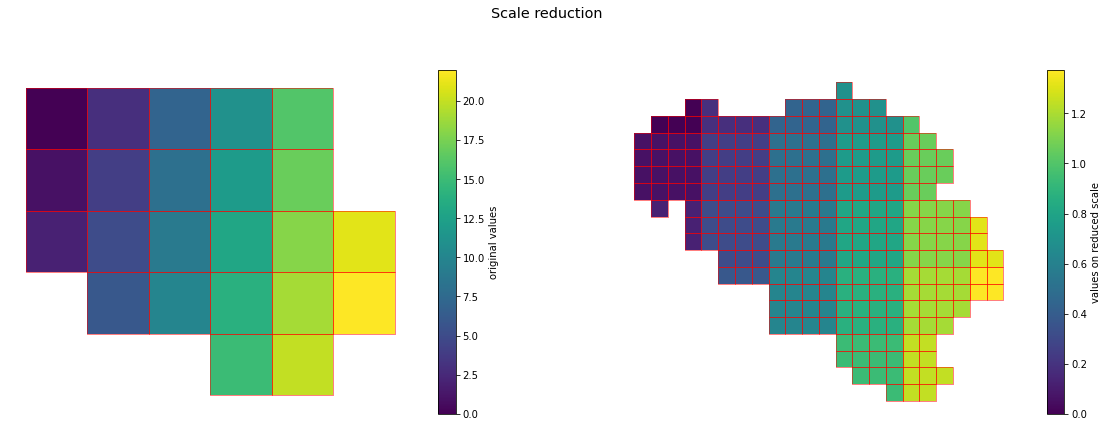

In [14]:
def testGridOverlay_1(grid, cellsize, how, rule, nscale):
    # create another grid with smaller scale/higher resolution
    proc = GridMaker(cores = NPROCESSES, mode = 'seq', tile = 1,
                     cell = [int(cell/nscale) for cell in cellsize])
    smallgrid = proc(GRID_BBOX, mask = GISCO_BORDER, 
                     crs = PROJECTION, trim = True, drop = True)
       
    # process with overlay
    proc = GridOverlay(cores = NPROCESSES, tile = 1, cell = cellsize, how = how)
    overlayed = proc(grid, smallgrid, rule = rule, columns = DUMMYCOL)
    overlayed = overlayed.sort_values(GridOverlay.COL_GRIDX, ignore_index = True)
    
    f, ax = mplt.subplots(1, 2, figsize=_FIGSIZE_)
    # figure 1
    grid.plot(ax = ax[0], column = DUMMYCOL, legend = True, 
              legend_kwds = {'label': 'original values', 'shrink':0.25})
    grid.boundary.plot(ax = ax[0], edgecolor = 'r', linewidth = 0.5)
    ax[0].set_axis_off() 
    # figure 2
    overlayed.plot(ax = ax[1], column = DUMMYCOL, legend = True, 
                   legend_kwds = {'label': 'values on reduced scale', 'shrink':0.25})  
    smallgrid.boundary.plot(ax = ax[1], edgecolor = 'r', linewidth = 0.5)
    ax[1].set_axis_off() 
    f.suptitle('Scale reduction', fontsize = 'x-large'); 
    f.subplots_adjust(top=+1.4)
    mplt.show()
     
    return overlayed

NSCALE = 4
HOW = 'intersection' # actually unchanged w.r.t. grid computation with testGridOverlay_0
RULE = 'sum'

overlayed = testGridOverlay_1(grid, CELLSIZE, HOW, RULE, NSCALE)

We check the ratio preservation of `DUMMYCOL` quantitative values when merging back (summing) the split cells from a lower scale (higher resolution):

In [15]:
def testGridOverlay_2(grid, overlayed, rule, nscale):
    try:
        idx, n = grid.index.tolist(), 1
        while n<nscale**2: # we look for a cell with at least nscale*nscale overlaps
            idx_poly = idx[int(np.random.random()*len(idx))]
            smalltest = overlayed[overlayed[GridOverlay.COL_POLIDX] == idx_poly]
            n = smalltest.shape[0]
        test = grid.iloc[idx_poly]
        assert (testval:=(test[DUMMYCOL] - smalltest[DUMMYCOL].agg(rule))) == 0 
    except:
        raise IOError('!!! Testing cell grid %s - %s overlap statistics: \033[1mERROR\033[0m !!!' 
                      % (rule, idx_poly, testval))
    else:
        print('Testing cell grid %s - %s overlap statistics: \033[1mOK\033[0m' % (rule, idx_poly))

    group = overlayed.groupby(GridOverlay.COL_POLIDX)

    try:
        assert (all(group[DUMMYCOL].unique().apply(lambda x: x[0])
                   == 
                   grid[DUMMYCOL] / (nscale * nscale))
                and # well... that's actually almost the same thing
                all(group[GridOverlay.COL_POLIDX].transform(lambda x: grid.iloc[x,grid.columns.get_loc(DUMMYCOL)]) 
                   == 
                   overlayed[DUMMYCOL] * (nscale * nscale))
               )
    except: 
        raise IOError('!!! Testing dummy scale reduction: \033[1mERROR\033[0m !!!')
    else:
        print('Testing dummy scale reduction: \033[1mOK\033[0m')
         
    try:
        assert all(group[DUMMYCOL].transform(lambda x: (nscale * nscale) * x.sum() / x.count()) 
                   == 
                   group[GridOverlay.COL_POLIDX].transform(lambda x: grid.iloc[x,grid.columns.get_loc(DUMMYCOL)])
                  )
    except:
        raise IOError('!!! Testing dumb ratio preservation: \033[1mERROR\033[0m !!!')
    else:
        print('Testing dumb ratio preservation: \033[1mOK\033[0m')

testGridOverlay_2(grid, overlayed, RULE, NSCALE)

Testing cell grid sum - 4 overlap statistics: OK
Testing dummy scale reduction: OK
Testing dumb ratio preservation: OK


We also test the statistics of overlaping polygons for the aggregating sum: <a id='Test3'></a>

In [16]:
def testGridOverlay_3(cellsize, how, rule): 
    idrows, idcols = GridMaker.get_pos_location(cellsize, GRID_BBOX, xypos = 'LLc') 
    polygrid = GridMaker.build_from_pos(cellsize, idrows, idcols)
    grid = gpd.GeoDataFrame({'geometry':polygrid}, crs = PROJECTION)
    
    proc1 = GridOverlay(cores = NPROCESSES, mode = 'prll', cell = cellsize, tile = 1, 
                        how = how, sorted = True) # preserve_polygon = True
    overlayed1 = proc1(NUTS_RG, grid, rule = None) # do nothing yet, just areas

    proc2 = GridOverlay(cores = NPROCESSES, mode = 'prll', cell = cellsize, tile = 2, 
                        how = how, sorted = True)
    overlayed2 = proc2(NUTS_RG, grid, rule = rule, columns = DUMMYCOL)

    idx = overlayed1[GridOverlay.COL_GRIDX].unique().tolist()
    n = 1
    while n<=1: # we look for a cell with at least 2 overlaps
        idx_grid = idx[int(np.random.random()*len(idx))] 
        test1 = overlayed1[overlayed1[GridOverlay.COL_GRIDX]==idx_grid]
        n = test1.shape[0]
    test2 = overlayed2[overlayed2[GridOverlay.COL_GRIDX]==idx_grid]
    
    try: # check one col only
        assert (testval:=((test1[DUMMYCOL]*test1[GridOverlay.COL_PCT]).agg(rule) 
                          - 
                          test2[DUMMYCOL]).values[0]) == 0 
        # all((test1[DUMMYCOL]*test1[GridOverlay.COL_PCT]).agg(rule) == test2[DUMMYCOL])
    except AssertionError:
        pass
        # raise IOError('!!! Cell grid %s: \033[1mERROR = %s\033[0m !!!' % (rule, idx_grid, testval))
    else:
        pass
        # print('Testing %s overlap statistics - cell grid %s: \033[1mOK\033[0m' % (rule, idx_grid))
    finally:
        return idx_grid, testval

CELLSIZE = [10000, 10000] 
HOW = 'union' # 'intersection'
RULE = 'sum'
PRESERVE_POLYGON = True

testval = -1
while testval !=0: 
    idx_grid, testval = testGridOverlay_3(CELLSIZE, HOW, RULE)
    if testval == 0:
        print('Testing %s overlap statistics - cell grid %s: \033[1mOK\033[0m' % (RULE, idx_grid))
    else:
        print ('!!! Testing %s overlap statistics - cell grid %s: \033[1mERROR = %s\033[0m !!!' 
               % (RULE, idx_grid, testval))

Testing sum overlap statistics - cell grid 458: OK


We visualise the new dataset where *(i)* geometries are intersections/unions (`HOW`) of the grid and the initial polygon representation (`NUTS_RG`), and *(ii)* dummy quantitative features are proportional to the values of the polygon they intersect with:

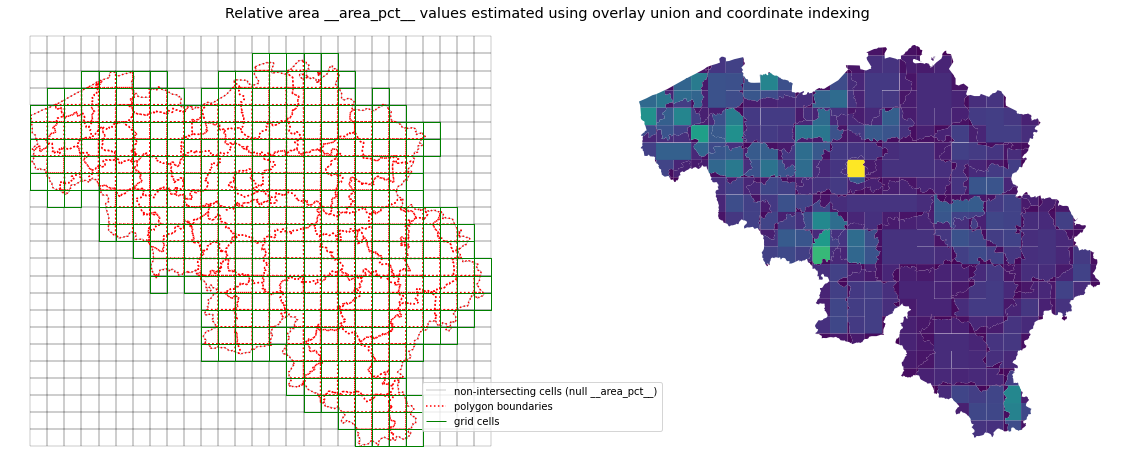

In [17]:
def testGridOverlay_4(cellsize, how, rule, preserve_polygon):
    proc = GridMaker(cores = NPROCESSES, mode = 'prll', cell = cellsize, tile = 5)
    grid = proc(GRID_BBOX, mask = GISCO_BORDER, crs = PROJECTION, trim = False)

    # f, ax = mplt.subplots(1, figsize = _FIGSIZE_)
    # grid.geometry[5:len(grid)].boundary.plot(ax = ax, edgecolor = 'k', linewidth = 0.5)
    # NUTS_RG.boundary.plot(ax = ax)
    # ax.set_axis_off(); ax.set_title('Grid and model layers - check for indexing')
    # mplt.show()

    proc = GridOverlay(cores = NPROCESSES, cell = cellsize, tile = 1, 
                       how = how, preserve_polygon = preserve_polygon, sorted = True, 
                       memory_split = False) # avoid overloading the memory
    overlayed = proc(NUTS_RG, grid, rule = None)
    
    overlay = overlayed[~np.isnan(overlayed[GridOverlay.COL_PCT])]
    grid.intersection(overlay.unary_union).head()

    f, ax = mplt.subplots(1,2, figsize=_FIGSIZE_)
    # figure 1
    (overlayed[np.isnan(overlayed[GridOverlay.COL_PCT])]
     .boundary.plot(ax = ax[0], edgecolor = 'k', linewidth = 0.2, 
                    label = 'non-intersecting cells (null %s)' % GridOverlay.COL_PCT)
    )  
    (overlay
     .boundary.plot(ax = ax[0], edgecolor = 'r', linewidth = 1.5, linestyle = 'dotted', label = 'polygon boundaries')
    )
    (grid
     .iloc[overlay[GridOverlay.COL_GRIDX].unique().tolist()]
     .boundary.plot(ax = ax[0], edgecolor = 'g', linewidth = 1, label = 'grid cells')
    )
    ax[0].set_axis_off(); ax[0].legend(bbox_to_anchor = (1.3, .2))
    # figure 2
    overlayed.plot(ax = ax[1], column = GridOverlay.COL_PCT, legend = False, 
                   legend_kwds = {'label': '%s values' % GridOverlay.COL_PCT, 'shrink':0.2})  
    ax[1].set_axis_off(); 
    
    f.suptitle('Relative area %s values estimated using overlay union and coordinate indexing'
               % GridOverlay.COL_PCT, fontsize = 'x-large'); 
    f.subplots_adjust(top=+1.4)
    mplt.show()

# parameters are unchanged w.r.t test testGridOverlay_3:
# CELLSIZE = [10000, 10000]
# HOW, RULE = 'union', 'sum'
PRESERVE_POLYGON = True

testGridOverlay_4(CELLSIZE, HOW, RULE, PRESERVE_POLYGON)

We run the geometric intersection between NUTS as a polygonal representation and an arbitrary grid together with the estimation of relative/proportional areas: <a id='Test5'></a>

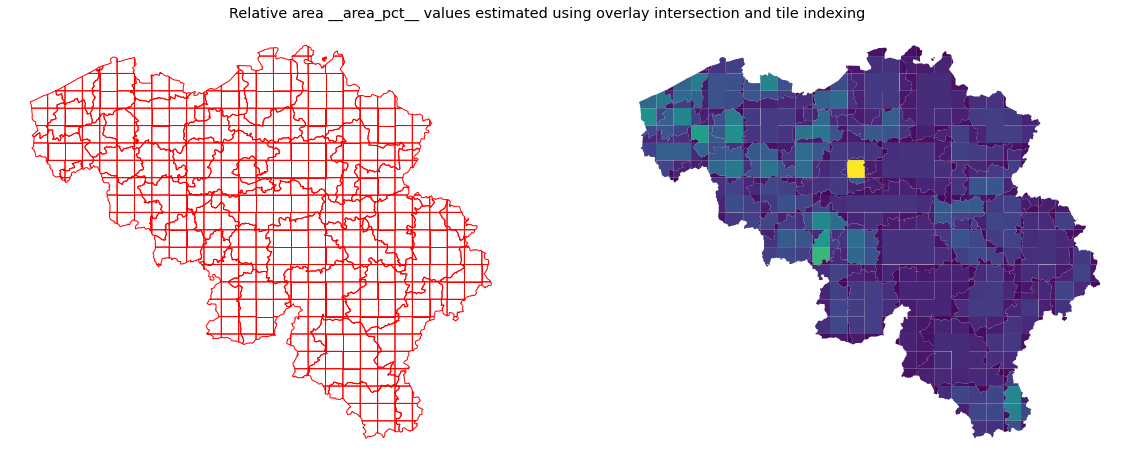

In [18]:
def testGridOverlay_5(cellsize, how):
    # Test 15 - with indexing through the use of a tiled grid with preindex __tile__ field

    proc = GridMaker(cores = NPROCESSES, mode = 'prll', tile = [5,5], # whatever...
                     cell = cellsize)
    grid = proc(GRID_BBOX, mask = GISCO_BORDER, crs = PROJECTION, trim = True, 
                drop = [GridMaker.COL_X, GridMaker.COL_Y, GridMaker.COL_INTERSECTS, GridMaker.COL_WITHIN])

    proc = GridOverlay(cores = NPROCESSES, cell = cellsize, how = how, tile = '__tile__', memory_split = False)
    overlayed = proc(NUTS_RG, grid, rule = None, drop = False) # True)
    
    f, ax = mplt.subplots(1, 2, figsize = _FIGSIZE_)
    # figure 1
    overlayed.boundary.plot(ax = ax[0], edgecolor = 'r', linewidth = 1, label = 'polygon/unit cell intersection')
    ax[0].set_axis_off() 
    # figure 2
    # overlayed[overlayed[GridOverlay.COL_PCT]>0].plot(column=GridOverlay.COL_PCT, legend=False, ax=ax[1])
    overlayed.plot(ax = ax[1], column = GridOverlay.COL_PCT, legend = False, 
                   legend_kwds = {'label': '%s values' % GridOverlay.COL_PCT, 'shrink':0.25})  
    ax[1].set_axis_off() 
    f.suptitle('Relative area %s values estimated using overlay intersection and tile indexing'
               % GridOverlay.COL_PCT, fontsize = 'x-large')
    f.subplots_adjust(top = +1.4)
    mplt.show()
    
    return grid, overlayed

CELLSIZE = [10000, 10000] 
HOW = 'intersection'

grid, overlayed = testGridOverlay_5(CELLSIZE, HOW)

Following, we use the resulting overlayed polygonal representation to "distribute" the values of the quantitative feature `DUMMYCOL` from the polygonal representation to the regular grid: <a id='Test6'></a>

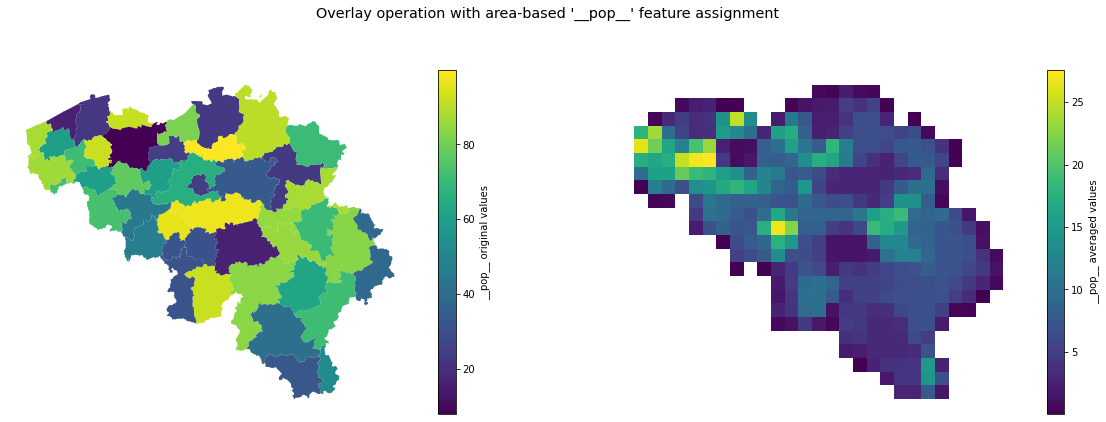

In [19]:
def testGridOverlay_6(grid, overlayed, rule):
    overlayed = GridOverlay.attribute_overlay(
        (grid
         .reset_index()
         .rename(columns={'index': GridOverlay.COL_GRIDX})
        ), 
        overlayed.drop(columns = ['geometry']), 
        rule, [DUMMYCOL,] # test with: cover = True
    )
    overlayed = gpd.GeoDataFrame(overlayed, crs = grid.crs)
 
    f, ax = mplt.subplots(1, 2, figsize = _FIGSIZE_)
    # figure 1
    NUTS_RG.plot(ax = ax[0], column = DUMMYCOL, legend = True, 
                  legend_kwds = {'label':'%s original values' % DUMMYCOL, 'shrink':0.25})                     
    ax[0].set_axis_off()
    # figure 2
    overlayed.plot(ax = ax[1], column = DUMMYCOL, legend = True,
                   legend_kwds = {'label':'%s averaged values' % DUMMYCOL, 'shrink':0.25})
    ax[1].set_axis_off();  
    f.suptitle("Overlay operation with area-based '%s' feature assignment" 
               % DUMMYCOL,  fontsize = 'x-large') 
    f.subplots_adjust(top=+1.4)
    mplt.show()
    
    return overlayed
    
RULE = 'sum'

overlayed = testGridOverlay_6(grid, overlayed, RULE)

## Comparison with areal interpolation algorithm of `tobler`<a id='ComparisonTobler'></a>

An algorithm for areal interpolation is also implemented in `tobler` as `tobler.area_weighted.area_interpolate`, that can be used for both intensive and extensive variables. We show here how our algorithm compares with that one when considering extensive variables only. 

In [20]:
try:
     import tobler
except ImportError:
    try:
        !{sys.executable} -m pip install tobler
    except:
        raise IOError("!!! Error importing tobler - this package is required in this section !!!")
finally:
    from tobler import area_weighted

For this exercise, we reuse the material presented in the notebook ["Areal interpolation: Tracts to Voting Precincts"](https://github.com/pysal/tobler/blob/master/notebooks/02_areal_interpolation_example.ipynb) that is distributed with `tobler` documentation. The same data are considered: 

In [21]:
tracts = gpd.read_file("https://ndownloader.figshare.com/files/20460645") 
precincts = gpd.read_file("https://ndownloader.figshare.com/files/20460549") 
tracts = tracts.to_crs(precincts.crs) 

Instead of the intensive variable analysed in the original notebook, we introduce a dummy extensive variable:

In [22]:
tracts['population'] = 1000 * np.random.random(size = tracts.shape[0])

We run an analysis similar to what is performed in the notebook, except that this time we consider the (extensive) `population` variable using the `area_interpolate` algorithm from the `tobler.area_weighted` module:

In [23]:
tobler_estimates = area_weighted.area_interpolate(tracts, precincts, extensive_variables=['population'])
tobler_estimates.sort_values(by='population', ascending = False).head()

,population,geometry
191,1495.121327,"POLYGON ((6172378.554 2322081.231, 6173148.501..."
194,1406.044165,"POLYGON ((6180997.830 2309158.040, 6180997.517..."
854,1323.505938,"POLYGON ((6260197.635 2278821.886, 6260719.566..."
835,1289.971310,"POLYGON ((6257541.410 2287476.997, 6257541.082..."
281,1279.524799,"POLYGON ((6163763.839 2284949.985, 6163769.975..."


The `area_interpolate` method of the `pygridmap.apps` module actually also work for target vector layers other than regular (square) grids. It will enable you run that same operation:

In [24]:
gridmap_estimates = area_interpolate(tracts, precincts, 'population')
gridmap_estimates = (gridmap_estimates
                     .drop(columns = gridmap_estimates.columns.difference(['geometry','population']))
                     .reindex(columns= ['population', 'geometry'])
                    )
gridmap_estimates.sort_values(by='population', ascending = False).head()

,population,geometry
523,1494.785176,"POLYGON ((6172378.554 2322081.231, 6173148.501..."
481,1406.044291,"POLYGON ((6180997.830 2309158.040, 6180997.517..."
280,1323.505953,"POLYGON ((6260197.635 2278821.886, 6260719.566..."
329,1289.971318,"POLYGON ((6257541.410 2287476.997, 6257541.082..."
291,1279.524857,"POLYGON ((6163763.839 2284949.985, 6163769.975..."


Let's visualise the interpolated data:

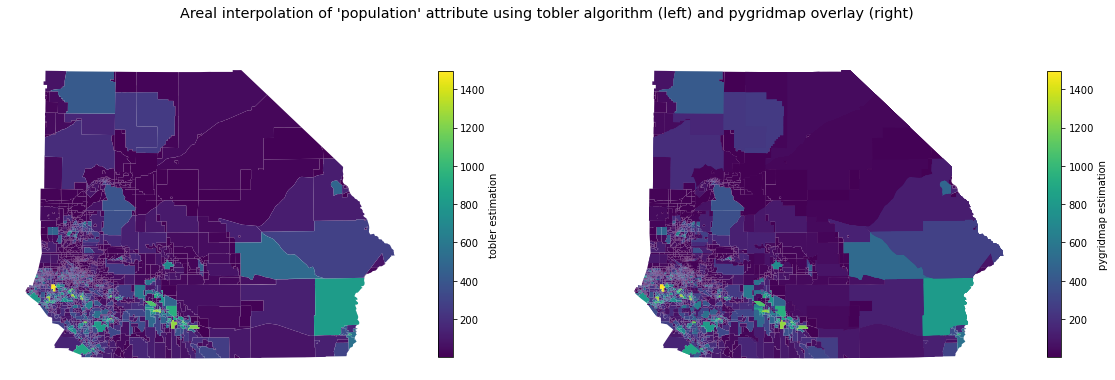

In [25]:
f, ax = mplt.subplots(1, 2, figsize = _FIGSIZE_)

# figure 1
#tracts.plot(ax = ax[0], column = 'population', legend = True,
#            legend_kwds = {'label':'population values', 'shrink':0.1})                     
#ax[0].set_axis_off()

# figure 2
tobler_estimates.plot(ax = ax[0], column = 'population', legend = True,
              legend_kwds = {'label':'tobler estimation', 'shrink':0.2})                     
ax[0].set_axis_off();  

# figure 3
gridmap_estimates.plot(ax = ax[1], column = 'population', legend = True, 
              legend_kwds = {'label':'pygridmap estimation', 'shrink':0.2})                     
ax[1].set_axis_off();  

f.suptitle("Areal interpolation of 'population' attribute using tobler algorithm (left) and pygridmap overlay (right)", 
           fontsize = 'x-large') 
f.subplots_adjust(top=+1.45)
mplt.show()

Note that we could have used those same functions to operate the areal interpolation of the source `NUTS_RG` over the target regular `grid` (see tests [#5](#Test5) and [#6](#Test6) in previous section), namely:

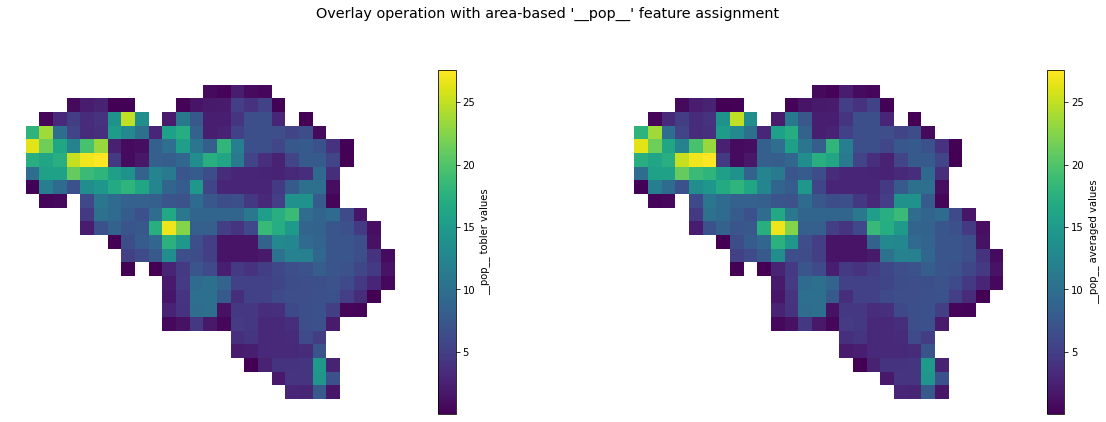

In [26]:
overlayed = area_interpolate(NUTS_RG, grid, [DUMMYCOL,]) # cell = CELLSIZE

toblered = area_weighted.area_interpolate(NUTS_RG, grid, extensive_variables = [DUMMYCOL,])

f, ax = mplt.subplots(1, 2, figsize = _FIGSIZE_)
# figure 1
toblered.plot(ax = ax[0], column = DUMMYCOL, legend = True, 
              legend_kwds = {'label':'%s tobler values' % DUMMYCOL, 'shrink':0.25})                     
ax[0].set_axis_off()
# figure 2
overlayed.plot(ax = ax[1], column = DUMMYCOL, legend = True,
               legend_kwds = {'label':'%s averaged values' % DUMMYCOL, 'shrink':0.25})
ax[1].set_axis_off();  
f.suptitle("Overlay operation with area-based '%s' feature assignment" 
           % DUMMYCOL,  fontsize = 'x-large') 
f.subplots_adjust(top=+1.4)
mplt.show()